## NAVCO 1.2 Participation Visualization
The original paper uses real-world protest participation data as a verification step. In this dataset, various types of protests (violent, nonviolent, or a combination) are presented alongside the size of participation (per capita and total) and the victory condition (regime win, some regime loss, or full nonviolent win). To find correlation between the size of the protest and the probability of succeeding, the paper performs a logistic regression and a rolling average of each of the data points (log of peak participation percentage, victory condition) which is performed here as well.

In [1]:
from agent_based import *
import pandas, numpy as np
import statsmodels.api as sm
%matplotlib inline
navcopath = "NAVCO/NAVCO12Data.xlsx"

/home/josh/Desktop/ABM/abm_venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


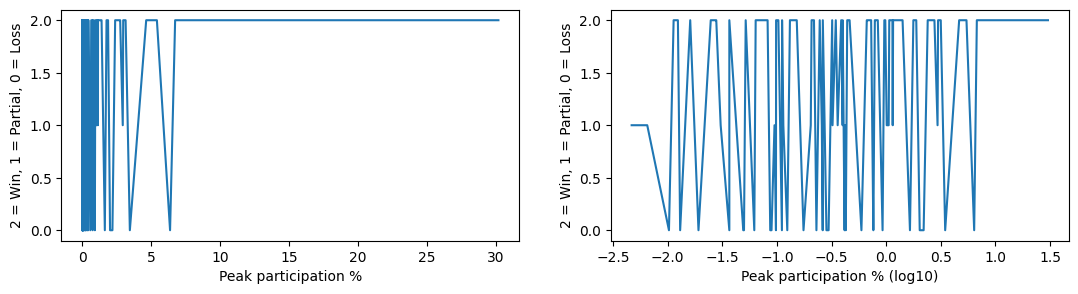

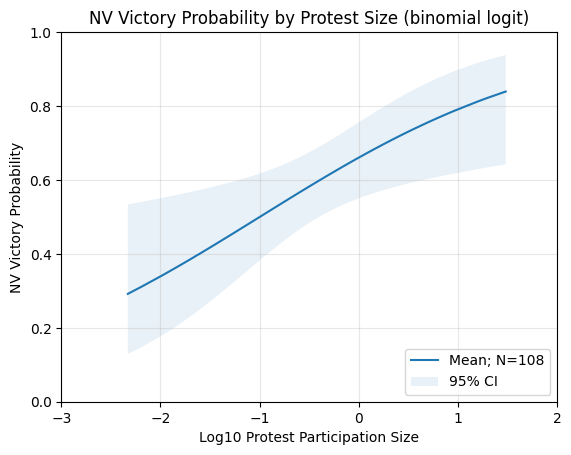

In [2]:
# side experiment; plots taking historical navco data and drawing correlation between participation and NV winning
def GetFilterNAVCO(RunCaseID = [4], # 1: all, 2: NV, 3: V, 4: only NV
                   IsLogistic = 1, # 1 logistic, 0 rolling avg
                   IsLog = 1, 
                   PlotOn = 1, # make or not make plots
                   FigureHandle = [], # empty -> default figs
                   IncludeNSize = 1, # 1 -> subplot of sample size
                   TruncateFirstPM = 0):
    RegimeChangeOnly = True    # all cases or only where regimes change
    
    result = pandas.read_excel(navcopath)
    if RegimeChangeOnly:
        result = result[result['REGIME CHANGE'] == 1]

    pct_part_data = result['PCT PARTICIPATION'] * 100  # filter out unused data
    NVorV_data = result[['NONVIOLENT', 'VIOLENT', 'CONTEMPORANEOUS VIOLENT CAMPAIGN']]
    success_data = result[['SUCCESS', 'LIMITED', 'FAILURE']]

    nonvio_data = NVorV_data[NVorV_data['NONVIOLENT'] == 1] # filter different cases (V, NV, full NV)
    vio_data = NVorV_data[NVorV_data['VIOLENT'] == 1]
    full_nv_data = nonvio_data[nonvio_data['CONTEMPORANEOUS VIOLENT CAMPAIGN'] == 0]

    success_value = success_data.dot([2, 1, 0]) # success "score" (2 win, 1 partial, 0 fail)
    
    for casenum in RunCaseID:
        if casenum not in [1,2,3,4]:
            raise Exception('Invalid case num!')
        run_perpop = pct_part_data if casenum == 1 else pct_part_data[nonvio_data.index] if casenum == 2 else pct_part_data[vio_data.index] if casenum == 3 else pct_part_data[full_nv_data.index]
        run_success_score = success_value if casenum == 1 else success_value[nonvio_data.index] if casenum == 2 else success_value[vio_data.index] if casenum == 3 else success_value[full_nv_data.index]

        
        if PlotOn:
            perpopsorted = run_perpop.sort_values()
            fig, axs = plt.subplots(1,2, figsize=(13,3))
            axs[0].plot(perpopsorted, run_success_score[perpopsorted.index])
            axs[0].set(xlabel="Peak participation %", ylabel="2 = Win, 1 = Partial, 0 = Loss")
            axs[1].plot(np.log10(perpopsorted), run_success_score[perpopsorted.index])
            axs[1].set(xlabel="Peak participation % (log10)", ylabel="2 = Win, 1 = Partial, 0 = Loss")
        
        
        run_success_score = (run_success_score == 2).astype(int)
        if IsLog:
            valid_indices = (run_perpop != 0)
            run_perpop = np.log10(run_perpop[valid_indices])
            run_success_score = run_success_score[valid_indices]

    # now do the rolling avg/logistic thing if its worth doing
        run_perpop.name = "pctpop"
        run_success_score.name = "result"

        binom_model = sm.GLM(run_success_score, sm.tools.add_constant(run_perpop), family=sm.families.Binomial())
        binom_model_results = binom_model.fit()
        predicted = binom_model_results.predict()

        pred = binom_model_results.get_prediction()
        df_pred = pred.summary_frame().sort_values('mean')        

        plt.figure()
        ax = plt.gca()
        ax.plot(sorted(run_perpop), sorted(predicted), label = f'Mean; N={len(run_perpop)}')
        ax.fill_between(sorted(run_perpop), df_pred.mean_ci_lower, df_pred.mean_ci_upper, alpha=0.1, label = '95% CI')
        ax.legend(loc='lower right')
        ax.set_xlim([-3, 2])
        ax.set_ylim([0, 1])
        ax.grid(alpha=0.3)
        ax.set_title("NV Victory Probability by Protest Size (binomial logit)")
        ax.set_ylabel("NV Victory Probability")
        ax.set_xlabel("Log10 Protest Participation Size")

        #interped = np.interp(xvalues,perpopsorted,predicted)
        #axs[0].plot(perpopsorted,predicted)
        #axs[1].plot(xvalues,interped)

        
        
#getFilterNAVCO

GetFilterNAVCO()